In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
from carbonplan_trace.v1.glas_allometric_eq import REALM_GROUPINGS
from carbonplan_trace.v1 import load
import carbonplan_trace.v1.model as m
import pandas as pd
from carbonplan_trace.v1.landsat_preprocess import access_credentials
import numpy as np

import matplotlib.pyplot as plt

In [3]:
access_key_id, secret_access_key = access_credentials()

In [4]:
realms = list(REALM_GROUPINGS.keys())

In [ ]:
# HPO
import itertools


def product_dict(**kwargs):
    keys = kwargs.keys()
    vals = kwargs.values()
    for instance in itertools.product(*vals):
        yield dict(zip(keys, instance))


param_set = {
    "learning_rate": [0.07, 0.05, 0.03],
    "max_depth": [10, 12, 14],
    "colsample_bytree": [0.5, 0.7, 0.9],
    "subsample": [0.5, 0.7, 0.9],
    "min_child_weight": [2, 4, 6],
    "lambda": [1, 1.5, 2],
    "alpha": [0, 0.5, 1],
    "gamma": [0, 0.5, 1],
}

groupings = [
    ["learning_rate"],
    ["max_depth"],
    ["colsample_bytree", "subsample", "min_child_weight"],
    ["lambda", "alpha", "gamma"],
]

dims = [list(range(len(param_set[g[0]]))) for g in groupings]
param_set_list = []
for orders in list(itertools.product(*dims)):
    d = {}
    for o, g in zip(orders, groupings):
        for k in g:
            d[k] = param_set[k][o]
    param_set_list.append(d)

In [6]:
def get_all_prediction_result(model, df_train, df_test, df_val):

    df_train["biomass_pred"] = model._predict(df_train)
    df_test["biomass_pred"] = model._predict(df_test)
    df_val["biomass_pred"] = model._predict(df_val)

    return df_train, df_test, df_val


def calculate_temporal_variability(df, y1=2007, y2=2008, precision=3):
    year1 = df.loc[df.year == y1, ["lat", "lon", "biomass"]]
    year2 = df.loc[df.year == y2, ["lat", "lon", "biomass"]]

    year1["lat_round"] = year1.lat.round(precision)
    year1["lon_round"] = year1.lon.round(precision)
    year2["lat_round"] = year2.lat.round(precision)
    year2["lon_round"] = year2.lon.round(precision)

    merged = year1.merge(
        year2, on=["lat_round", "lon_round"], suffixes=["_year1", "_year2"]
    )

    mae = (merged.biomass_year2 - merged.biomass_year1).abs().mean()
    me = (merged.biomass_year2 - merged.biomass_year1).mean()

    return {"mae": mae, "me": me}

Building model for afrotropic realm
    size of entire df is 0.6Gb
    training sample size = 9505157
    testing sample size = 1655429
    eval sample size = 1637498
    rf_afrotropic_all model already exists, loading from s3://carbonplan-climatetrace/v1/models/rf_afrotropic_all.joblib


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    4.5s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    8.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    4.4s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    8.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    0

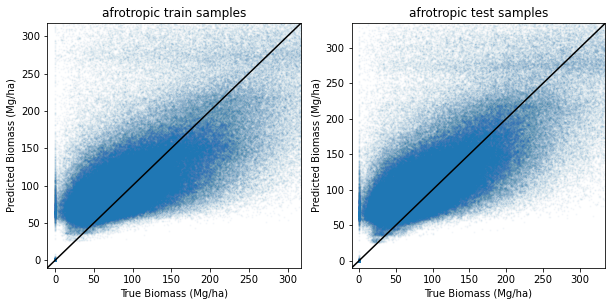

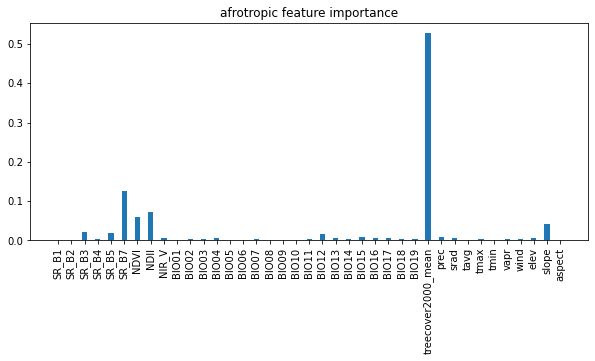

Building model for australia realm
    size of entire df is 0.09Gb
    training sample size = 1307605
    testing sample size = 215468
    eval sample size = 300193
    rf_australia_all model already exists, loading from s3://carbonplan-climatetrace/v1/models/rf_australia_all.joblib


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    0.1s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    0.1s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    0

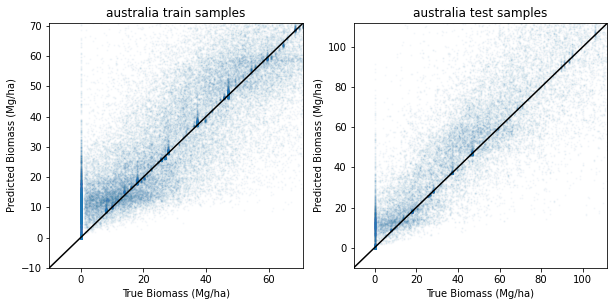

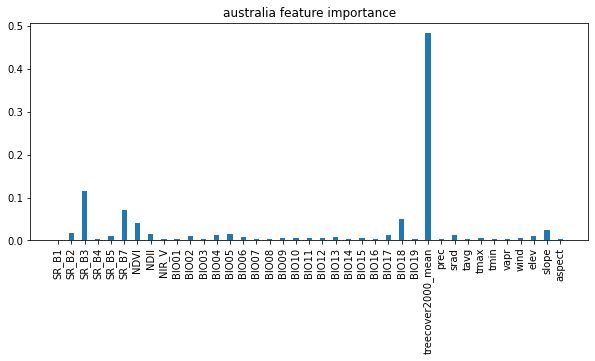

Building model for nearctic realm
    size of entire df is 0.51Gb
    training sample size = 8716396
    testing sample size = 1445205
    eval sample size = 677087
    rf_nearctic_all model already exists, loading from s3://carbonplan-climatetrace/v1/models/rf_nearctic_all.joblib


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    4.1s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    7.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    4.2s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    7.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    0

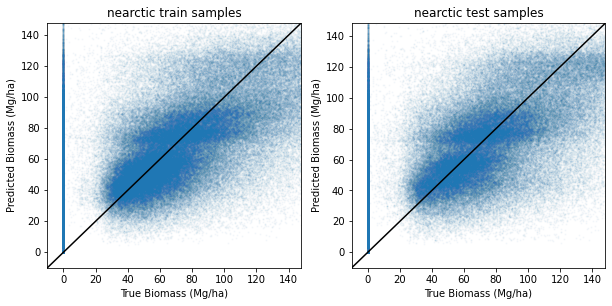

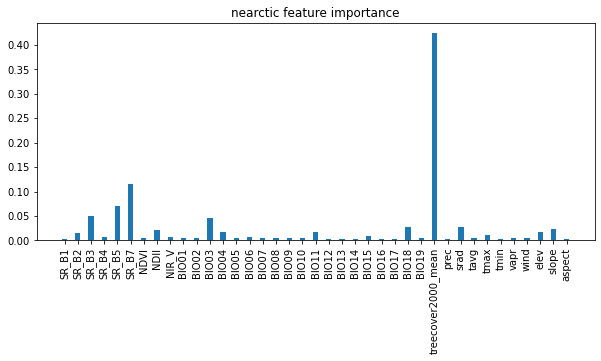

Building model for neotropic realm
    size of entire df is 0.5Gb
    training sample size = 7511952
    testing sample size = 1481009
    eval sample size = 1581596
    rf_neotropic_all model already exists, loading from s3://carbonplan-climatetrace/v1/models/rf_neotropic_all.joblib


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    3.2s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    5.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    3.2s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    5.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    0

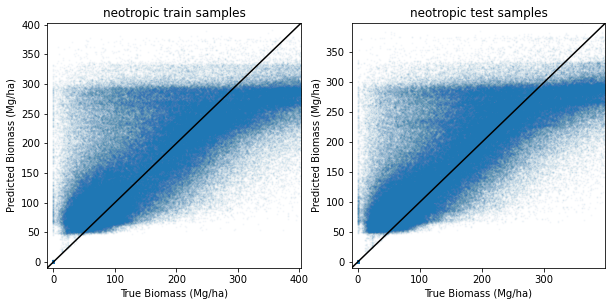

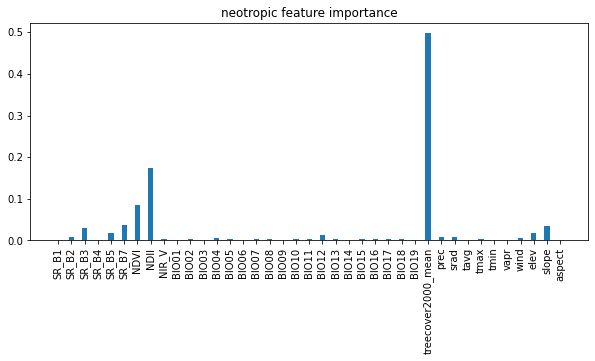

Building model for palearctic realm
    size of entire df is 1.09Gb
    training sample size = 18586479
    testing sample size = 2930771
    eval sample size = 1751734
    rf_palearctic_all model already exists, loading from s3://carbonplan-climatetrace/v1/models/rf_palearctic_all.joblib


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    6.4s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:   11.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    0.8s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    6.2s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:   11.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    0

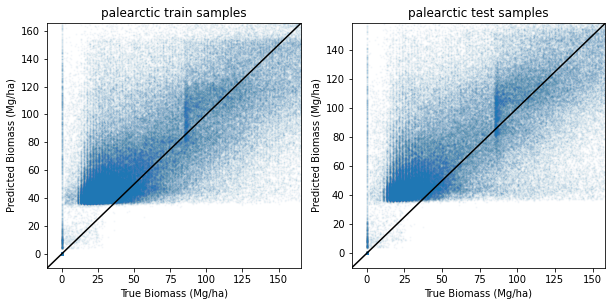

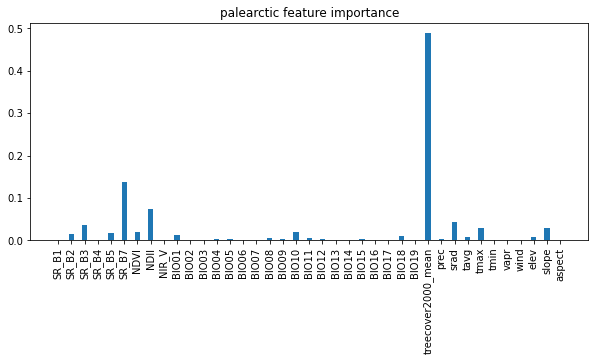

Building model for tropical_asia realm
    size of entire df is 0.2Gb
    training sample size = 3017891
    testing sample size = 586003
    eval sample size = 609780
    rf_tropical_asia_all model already exists, loading from s3://carbonplan-climatetrace/v1/models/rf_tropical_asia_all.joblib


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    1.4s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    2.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    1.4s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:    2.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    0

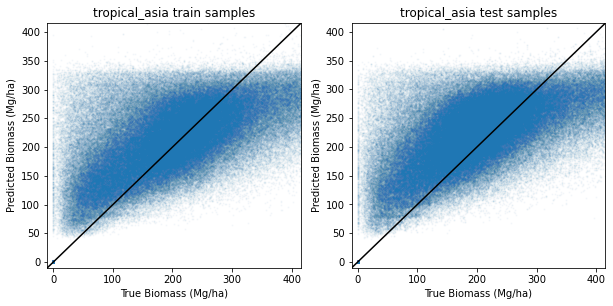

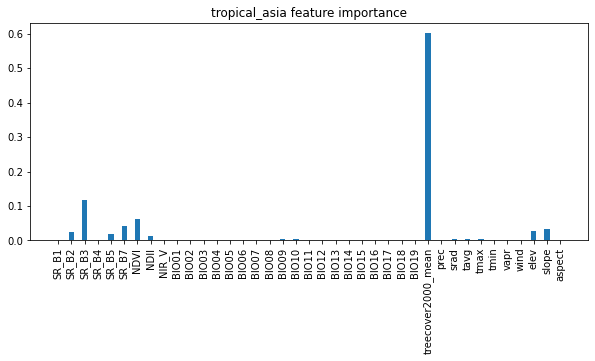

In [78]:
scores = []
random_split = False
reload = False
overwrite = False

for model_class in [m.random_forest_model]:  # m.xgb_model
    for realm in realms:
        print(f"Building model for {realm} realm")

        # load data, add year information
        df = load.training(
            realm=realm,
            reload=reload,
            access_key_id=access_key_id,
            secret_access_key=secret_access_key,
        )
        print(f"    size of entire df is {round(df.size / 1e9, 2)}Gb")

        for strategy in ["last"]: #["first", "last", "no"]:
            # split into train/test based on year
            df_train, df_test, df_val = m.train_test_split_based_on_year(
                df, val_strategy=strategy, random_train_test=random_split
            )
            print(f"    training sample size = {len(df_train)}")
            print(f"    testing sample size = {len(df_test)}")
            print(f"    eval sample size = {len(df_val)}")

            # build 2 models: 1) baseline/mean, 2) xgboost
            # TODO: build linear model as another baseline model
            # m.baseline_model, m.gradient_boost_model, m.random_forest_model

            for params in [{}]:

                model = model_class(
                    realm=realm,
                    df_train=df_train,
                    df_test=df_test,
                    output_folder="s3://carbonplan-climatetrace/v1/models/",
                    overwrite=overwrite,
                    validation_year="none",
                    params=params,
                )

                for split, sub in zip(
                    ("train", "test", "val"), (df_train, df_test, df_val)
                ):
                    if len(sub) > 0:
                        model_score = model.evaluate(sub)
                        model_score["model_name"] = model.name
                        model_score["split"] = split
                        model_score["realm"] = realm
                        model_score["validation_year"] = strategy
                        model_score["random_split"] = random_split
                        model_score["sample_size"] = len(sub)
                        model_score.update(params)
                        scores.append(model_score)
                
                
                df_train["biomass_pred"] = model.predict(df_train)
                df_test["biomass_pred"] = model.predict(df_test)
                
            plt.figure(figsize=(10, 4.5))
            plt.subplot(1, 2, 1)
            plot_scatter(df_train, title=f'{realm} train samples')
            plt.subplot(1, 2, 2)
            plot_scatter(df_test, title=f'{realm} test samples')
            plt.savefig(f"{realm}_model_scatter.png")
            plt.show()
            plt.close()
            
            plt.figure(figsize=(10, 4))
            plt.title(f'{realm} feature importance')
            xticks = np.arange(len(m.features)) * 2
            plt.bar(xticks, model.model.feature_importances_)
            plt.xticks(ticks=xticks, labels=m.features, rotation='vertical')
            plt.savefig(f'{realm}_feature_imp.png')
            plt.show()
            plt.close()
                
scores = pd.DataFrame(scores)

In [75]:
def plot_scatter(sub, title, n=500000):
    xmin = -10
    size = min(len(sub), n)
    toplot = sub.sample(n=size)
    xmax = toplot.biomass.quantile(.95)
    plt.scatter(toplot.biomass, toplot.biomass_pred, s=1, alpha=0.03)
    plt.plot([xmin, xmax], [xmin, xmax], 'k')
    plt.xlabel('True Biomass (Mg/ha)')
    plt.ylabel('Predicted Biomass (Mg/ha)')
    plt.xlim(xmin, xmax)
    plt.ylim(xmin, xmax)
    plt.title(title)

In [81]:
df_train.year.unique()

array([2003, 2004, 2005, 2006])

In [79]:
scores

,bias,mae,r2,model_name,split,realm,validation_year,random_split,sample_size
0,-2.624972,35.072517,0.698763,rf_afrotropic_all,train,afrotropic,last,False,9505157
1,2.861831,35.843078,0.716451,rf_afrotropic_all,test,afrotropic,last,False,1655429
2,12.350213,35.891570,0.642542,rf_afrotropic_all,val,afrotropic,last,False,1637498
3,-0.212937,2.968683,0.875447,rf_australia_all,train,australia,last,False,1307605
4,0.032235,4.230558,0.883143,rf_australia_all,test,australia,last,False,215468
5,0.943777,4.298002,0.850291,rf_australia_all,val,australia,last,False,300193
6,-0.002758,17.833439,0.622221,rf_nearctic_all,train,nearctic,last,False,8716396
7,-0.294262,16.427501,0.633068,rf_nearctic_all,test,nearctic,last,False,1445205
8,0.748233,17.304178,0.645970,rf_nearctic_all,val,nearctic,last,False,677087
9,-3.722519,44.445011,0.708900,rf_neotropic_all,train,neotropic,last,False,7511952


In [ ]:
for random_split in [True, False]:
    print(random_split)
    sub = scores.loc[
        (scores.split == "val") & (scores.random_split == random_split)
    ]
    print(
        f"validation score = {(sub.r2 * sub.sample_size).sum() / sub.sample_size.sum()}"
    )
    sub = scores.loc[
        (scores.split == "test") & (scores.random_split == random_split)
    ]
    print(
        f"testing score    = {(sub.r2 * sub.sample_size).sum() / sub.sample_size.sum()}"
    )
    sub = scores.loc[
        (scores.split == "train") & (scores.random_split == random_split)
    ]
    print(
        f"training score   = {(sub.r2 * sub.sample_size).sum() / sub.sample_size.sum()}"
    )

In [ ]:
for validation_year in ["first", "last"]:
    print(validation_year)
    sub = scores.loc[
        (scores.split == "val") & (scores.validation_year == validation_year)
    ]
    print(
        f"validation score = {(sub.r2 * sub.sample_size).sum() / sub.sample_size.sum()}"
    )
    sub = scores.loc[
        (scores.split == "test") & (scores.validation_year == validation_year)
    ]
    print(
        f"testing score    = {(sub.r2 * sub.sample_size).sum() / sub.sample_size.sum()}"
    )
    sub = scores.loc[
        (scores.split == "train") & (scores.validation_year == validation_year)
    ]
    print(
        f"training score   = {(sub.r2 * sub.sample_size).sum() / sub.sample_size.sum()}"
    )

In [ ]:
temporal_variability = pd.read_csv("temporal_variability.csv")

In [ ]:
temporal_variability["realm"] = temporal_variability.model_name.apply(
    lambda x: x.split("_")[1]
)
temporal_variability["model_type"] = temporal_variability.model_name.apply(
    lambda x: x.split("_")[0]
)

sample_size = (
    scores.loc[
        (scores.random_split == True)
        & (scores.model_name.str.startswith("xgb"))
    ]
    .groupby("realm")
    .sample_size.sum()
)

In [ ]:
# weighted average
merged = temporal_variability.loc[
    temporal_variability.random_split != True
].merge(sample_size, how="left", on="realm")
name_dict = {
    "gb": "gradient boosting",
    "ground": "lidar derived",
    "rf": "random forest",
    "xgb": "xgboost",
}
merged["model_type"] = merged.model_type.apply(lambda x: name_dict[x])

print(
    "Biomass MAE between years 2007 and 2008 of the same location using different model architecture"
)
print("")
for model, g in merged.groupby("model_type"):
    print(
        model.ljust(20),
        np.round((g.mae * g.sample_size).sum() / g.sample_size.sum(), 4),
    )

In [ ]:
# simple average
temporal_variability.loc[temporal_variability.random_split != True].merge(
    sample_size, how="left", on="realm"
).groupby("model_type").mae.mean()

In [ ]:
scores = pd.read_csv("HPO_1.csv")

In [ ]:
df.loc[df.split == "test"].groupby(
    ["learning_rate", "max_depth", "colsample_bytree", "lambda"]
).mean().sort_values(by="r2")

In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# igbp_encoder = OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore').fit(df_train[['igbp']])
#     # one hot encoding for igbp
#     encoded_igbp = igbp_encoder.transform(X[['igbp']])
#     X = X.drop(['igbp'], axis=1)
#     for i in range(encoded_igbp.shape[1]):
#         X[f'igbp_cat_{str(i+1)}'] = encoded_igbp[:, i]